### Q1/ Débruitez texte_bruit.gif. Réfléchissez: Quel est le type de bruit dans cette image? 

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

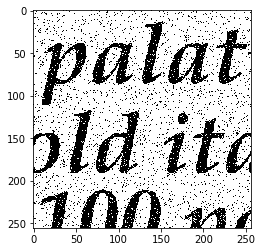

In [17]:
imageName ="texte_bruit.png"

# Read the input image
image = cv2.imread(imageName)

plt.imshow(image)

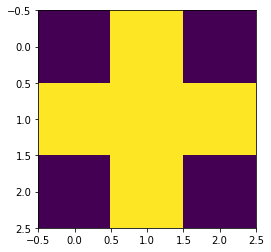

In [50]:
# Get structuring element/kernel which will be used for dilation
kSize = (3,3)
kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kSize)
plt.imshow(kernel1)

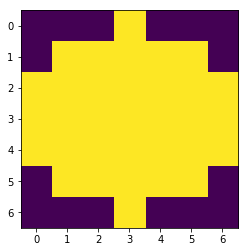

In [91]:
# Get structuring element/kernel which will be used for erosion
kSize = (7,7)
kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kSize)
plt.imshow(kernel2)

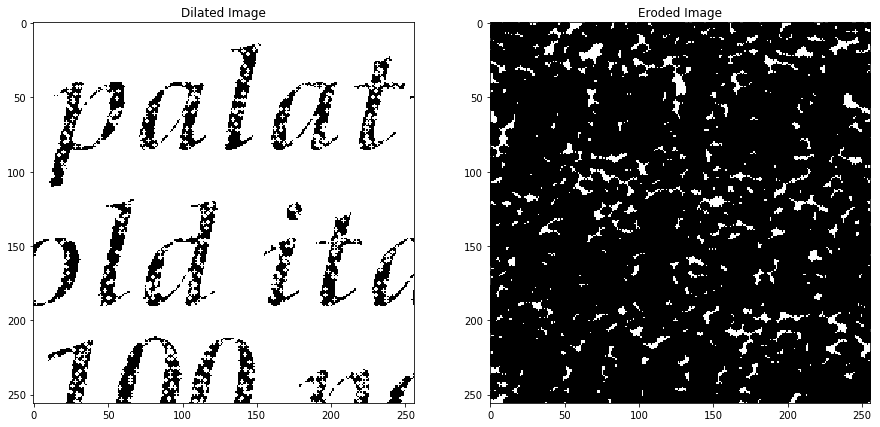

In [92]:
# Apply dilate function on the input image
imageDilated = cv2.dilate(image, kernel1)

# Eroding the image , decreases brightness of image
imageEroded = cv2.erode(image, kernel2)

plt.figure(figsize=[15,15])
plt.subplot(121);plt.imshow(imageDilated);plt.title("Dilated Image")
plt.subplot(122);plt.imshow(imageEroded);plt.title("Eroded Image");

Text(0.5, 1.0, 'Final Image')

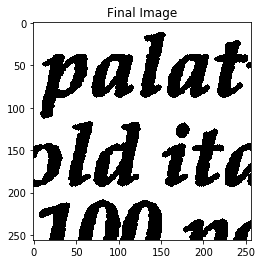

In [94]:
# Dilation + erosion result

imagefilter = cv2.erode(imageDilated , kernel2)


plt.imshow(imagefilter)
plt.title("Final Image")


### Q2/ faire les tutoriels :

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

from skimage.morphology import disk
from skimage import data
from skimage.filters import rank
from skimage.util import img_as_ubyte

from skimage import util, filters, color

#### Watershed segmentation

The watershed is a classical algorithm used for segmentation, that is, for separating different objects in an image.

Starting from user-defined markers, the watershed algorithm treats pixels values as a local topography (elevation). The algorithm floods basins from the markers until basins attributed to different markers meet on watershed lines. In many cases, markers are chosen as local minima of the image, from which basins are flooded.

In the example below, two overlapping circles are to be separated. To do so, one computes an image that is the distance to the background. The maxima of this distance (i.e., the minima of the opposite of the distance) are chosen as markers and the flooding of basins from such markers separates the two circles along a watershed line.

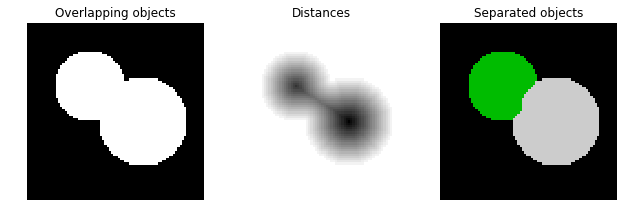

In [148]:
# Generate an initial image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
image = np.logical_or(mask_circle1, mask_circle2)

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=image)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

#### Markers for watershed transform

The watershed is a classical algorithm used for segmentation, that is, for separating different objects in an image.

Here a marker image is built from the region of low gradient inside the image. In a gradient image, the areas of high values provide barriers that help to segment the image. Using markers on the lower values will ensure that the segmented objects are found.

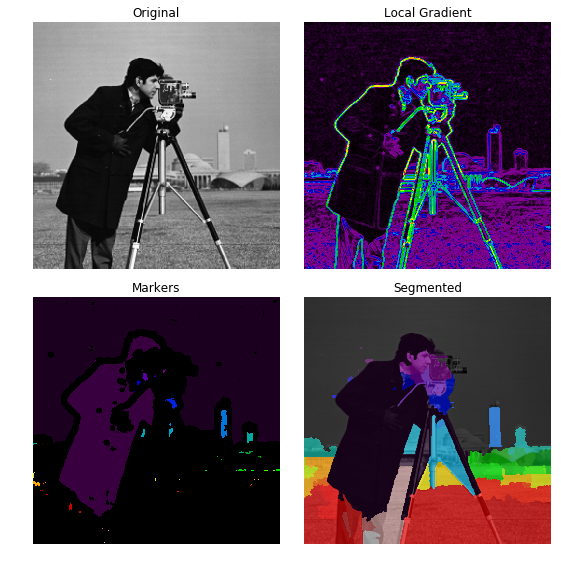

In [149]:
image = img_as_ubyte(data.camera())

# denoise image
denoised = rank.median(image, disk(2))

# find continuous region (low gradient -
# where less than 10 for this image) --> markers
# disk(5) is used here to get a more smooth image
markers = rank.gradient(denoised, disk(5)) < 10
markers = ndi.label(markers)[0]

# local gradient (disk(2) is used to keep edges thin)
gradient = rank.gradient(denoised, disk(2))

# process the watershed
labels = watershed(gradient, markers)

# display results
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title("Original")

ax[1].imshow(gradient, cmap=plt.cm.nipy_spectral)
ax[1].set_title("Local Gradient")

ax[2].imshow(markers, cmap=plt.cm.nipy_spectral)
ax[2].set_title("Markers")

ax[3].imshow(image, cmap=plt.cm.gray)
ax[3].imshow(labels, cmap=plt.cm.nipy_spectral, alpha=.7)
ax[3].set_title("Segmented")

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

#### Find Regular Segments Using Compact Watershed

The watershed transform is commonly used as a starting point for many segmentation algorithms. However, without a judicious choice of seeds, it can produce very uneven fragment sizes, which can be difficult to deal with in downstream analyses.

The compact watershed transform remedies this by favoring seeds that are close to the pixel being considered.

Both algorithms are implemented in the skimage.morphology.watershed() function. To use the compact form, simply pass a compactness value greater than 0.

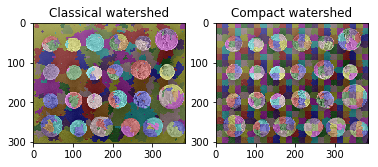

In [150]:
coins = data.coins()
edges = filters.sobel(coins)

grid = util.regular_grid(coins.shape, n_points=468)

seeds = np.zeros(coins.shape, dtype=int)
seeds[grid] = np.arange(seeds[grid].size).reshape(seeds[grid].shape) + 1

w0 = watershed(edges, seeds)
w1 = watershed(edges, seeds, compactness=0.01)

fig, (ax0, ax1) = plt.subplots(1, 2)

ax0.imshow(color.label2rgb(w0, coins, bg_label=-1))
ax0.set_title('Classical watershed')

ax1.imshow(color.label2rgb(w1, coins, bg_label=-1))
ax1.set_title('Compact watershed')

plt.show()


### Q3/ segmenter les images .png

Comparison of four low level segmentaion methods:

Felzenszwalb’s efficient graph based segmentation:

This fast 2D image segmentation algorithm, proposed in 1 is popular in the computer vision community. The algorithm has a single scale parameter that influences the segment size. The actual size and number of segments can vary greatly, depending on local contrast.

Efficient graph-based image segmentation, Felzenszwalb, P.F. and Huttenlocher, D.P. International Journal of Computer Vision, 2004

Quickshift image segmentation:

Quickshift is a relatively recent 2D image segmentation algorithm, based on an approximation of kernelized mean-shift. Therefore it belongs to the family of local mode-seeking algorithms and is applied to the 5D space consisting of color information and image location.

One of the benefits of quickshift is that it actually computes a hierarchical segmentation on multiple scales simultaneously.

Quickshift has two main parameters: sigma controls the scale of the local density approximation, max_dist selects a level in the hierarchical segmentation that is produced. There is also a trade-off between distance in color-space and distance in image-space, given by ratio.

Quick shift and kernel methods for mode seeking, Vedaldi, A. and Soatto, S. European Conference on Computer Vision, 2008

SLIC - K-Means based image segmentation:

This algorithm simply performs K-means in the 5d space of color information and image location and is therefore closely related to quickshift. As the clustering method is simpler, it is very efficient. It is essential for this algorithm to work in Lab color space to obtain good results. The algorithm quickly gained momentum and is now widely used. See 3 for details. The compactness parameter trades off color-similarity and proximity, as in the case of Quickshift, while n_segments chooses the number of centers for kmeans.

Radhakrishna Achanta, Appu Shaji, Kevin Smith, Aurelien Lucchi, Pascal Fua, and Sabine Suesstrunk, SLIC Superpixels Compared to State-of-the-art Superpixel Methods, TPAMI, May 2012.

Compact watershed segmentation of gradient images:

Instead of taking a color image as input, watershed requires a grayscale gradient image, where bright pixels denote a boundary between regions. The algorithm views the image as a landscape, with bright pixels forming high peaks. This landscape is then flooded from the given markers, until separate flood basins meet at the peaks. Each distinct basin then forms a different image segment. 

As with SLIC, there is an additional compactness argument that makes it harder for markers to flood faraway pixels. This makes the watershed regions more regularly shaped. 

In [151]:
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

In [189]:
def segmentation_comp (path):

    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    segments_fz = felzenszwalb(img, scale=750, sigma=0.8, min_size=150)
    segments_slic = slic(img, n_segments=10, compactness=10, sigma=0.8)
    segments_quick = quickshift(img, kernel_size=10, max_dist=50, ratio=0.75)
    gradient = sobel(rgb2gray(img))
    segments_watershed = watershed(gradient, markers=25, compactness=0.001)

    print(f"Felzenszwalb number of segments: {len(np.unique(segments_fz))}")
    print(f"SLIC number of segments: {len(np.unique(segments_slic))}")
    print(f"Quickshift number of segments: {len(np.unique(segments_quick))}")

    fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

    ax[0, 0].imshow(mark_boundaries(img, segments_fz))
    ax[0, 0].set_title("Felzenszwalbs's method")
    ax[0, 1].imshow(mark_boundaries(img, segments_slic))
    ax[0, 1].set_title('SLIC')
    ax[1, 0].imshow(mark_boundaries(img, segments_quick))
    ax[1, 0].set_title('Quickshift')
    ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
    ax[1, 1].set_title('Compact watershed')

    for a in ax.ravel():
        a.set_axis_off()

    plt.tight_layout()
    plt.show()
    

Felzenszwalb number of segments: 6
SLIC number of segments: 11
Quickshift number of segments: 16


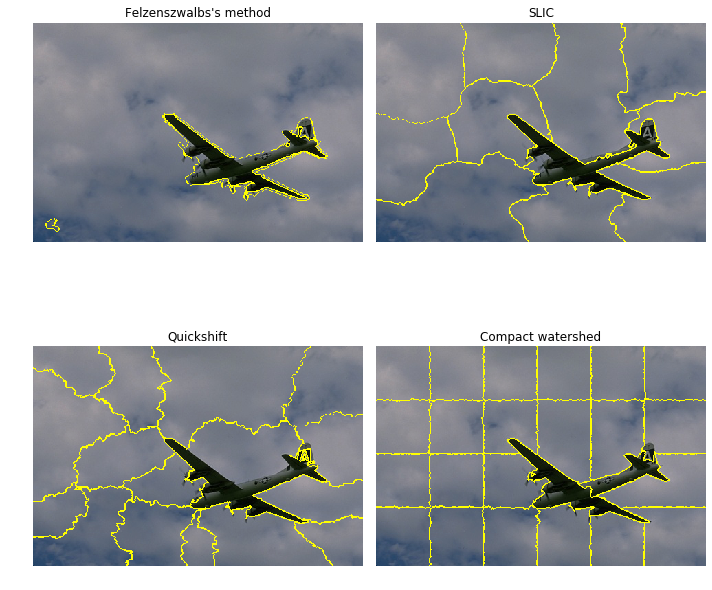

In [190]:
segmentation_comp('3096_HR.png')

Felzenszwalb number of segments: 33
SLIC number of segments: 10
Quickshift number of segments: 19


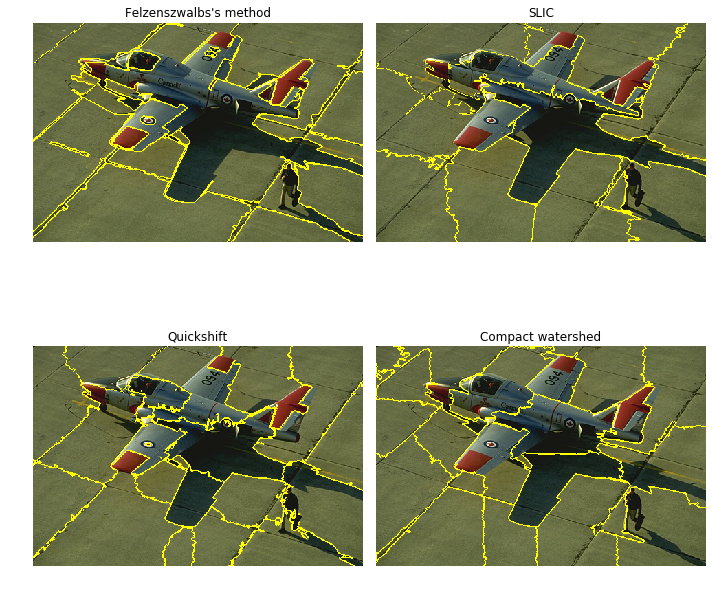

In [191]:
segmentation_comp('37073_HR.png')

Felzenszwalb number of segments: 26
SLIC number of segments: 8
Quickshift number of segments: 26


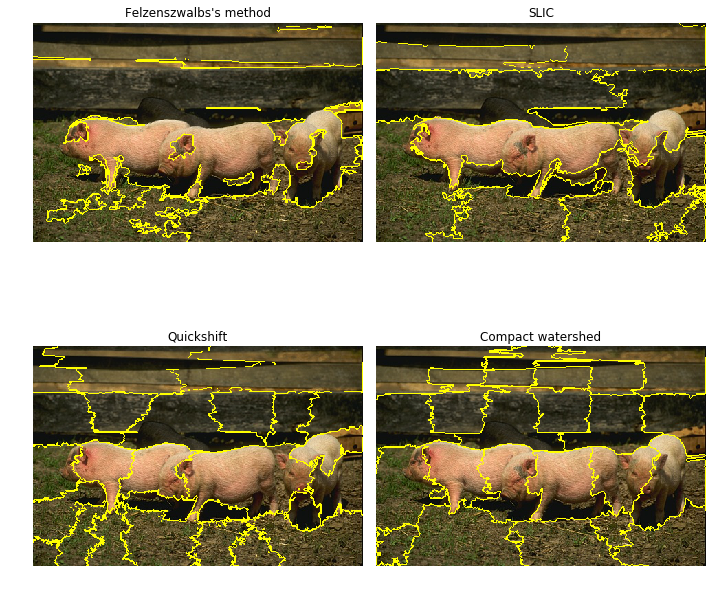

In [192]:
segmentation_comp('66053_HR.png')

Felzenszwalb number of segments: 27
SLIC number of segments: 7
Quickshift number of segments: 18


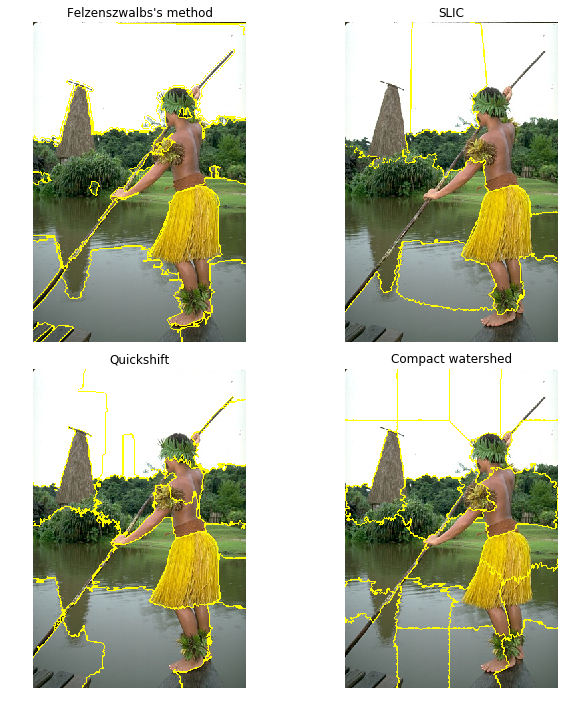

In [193]:
segmentation_comp('101087_HR.png')

As expected, results are not really good and really consistent. Indeed we can see poor results even after trying to find the good hyperparameters. And most important, even after finding them, results are not consistent, it means that we need to adapt it each image. 
As a consequence, we can see how relevant depp learning approaches are in this filed to improve the segmentation task. 